In [22]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames: thị 4 ảnh mẫu ngẫu nhiên...
#         print(os.path.join(dirname, filename))

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# HÀM TẠO CHỈ MỤC FILE (INDEXING)

In [27]:
def create_file_index(root_dir):
    """Quét toàn bộ thư mục và tạo từ điển {tên_file: đường_dẫn}"""
    file_map = {}
    print(f"🔄 Đang quét index thư mục: {root_dir} ...")
    for dirpath, _, filenames in os.walk(root_dir):
        for f in filenames:
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                file_map[f] = os.path.join(dirpath, f)
    print(f"✅ Đã index xong {len(file_map)} ảnh.")
    return file_map

# HÀM TRỰC QUAN HÓA & THỐNG KÊ

In [32]:
def analyze_and_visualize(json_path, image_map, num_visualize=3):
    # --- A. LOAD DỮ LIỆU ---
    if not os.path.exists(json_path):
        print("Lỗi: Không tìm thấy file JSON!")
        return

    with open(json_path, 'r') as f:
        coco = json.load(f)
    
    categories = {cat['id']: cat['name'] for cat in coco['categories']}
    images = coco['images']
    annotations = coco['annotations']
    
    print(f"Dữ liệu JSON: {len(images)} ảnh, {len(annotations)} hộp nhãn (boxes).")
    print("-" * 50)

    # --- B. TRỰC QUAN HÓA ẢNH (VISUALIZATION) ---
    print(f"Đang hiển thị {num_visualize} ảnh mẫu ngẫu nhiên...")
    
    # Lọc ra các ảnh có tồn tại trong thư mục (dựa vào image_map)
    valid_images = [img for img in images if img['file_name'] in image_map]
    
    if not valid_images:
        # Thử logic tìm kiếm mờ (cho trường hợp tên file bị đổi chút ít như _crop)
        print("Không tìm thấy tên file chính xác, thử tìm kiếm tương đối...")
        valid_images = []
        for img in images:
            fname = img['file_name']
            # Logic: Nếu tên trong JSON là 'abc_crop.jpg' thì tìm 'abc' trong map
            key_search = fname.split('_crop')[0] if '_crop' in fname else fname
            for map_key, map_path in image_map.items():
                if key_search in map_key:
                    img['full_path'] = map_path # Gán đường dẫn tìm được
                    valid_images.append(img)
                    break
    else:
        # Gán đường dẫn trực tiếp
        for img in valid_images:
            img['full_path'] = image_map[img['file_name']]

    # Vẽ ảnh
    if valid_images:
        samples = random.sample(valid_images, min(num_visualize, len(valid_images)))
        plt.figure(figsize=(20, 6))
        
        for i, img_info in enumerate(samples):
            img_path = img_info['full_path']
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Lấy annotation của ảnh này
            img_anns = [ann for ann in annotations if ann['image_id'] == img_info['id']]
            
            # Vẽ Box
            for ann in img_anns:
                x, y, w, h = [int(v) for v in ann['bbox']]
                cat_name = categories.get(ann['category_id'], 'Unknown')
                cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
                cv2.putText(img, cat_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
            
            plt.subplot(1, num_visualize, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"ID: {img_info['id']} | Lỗi: {len(img_anns)}")
        plt.show()
    else:
        print("Không tìm thấy ảnh nào khớp để hiển thị.")

    # --- C. THỐNG KÊ DỮ LIỆU (STATISTICS) ---
    print("Đang vẽ biểu đồ thống kê...")
    
    class_names = []
    box_areas = []
    aspect_ratios = []
    centers_x = []
    centers_y = []
    
    # Lấy kích thước ảnh đầu tiên để làm chuẩn cho heatmap
    img_w = images[0]['width']
    img_h = images[0]['height']

    for ann in annotations:
        class_names.append(categories[ann['category_id']])
        x, y, w, h = ann['bbox']
        box_areas.append(np.sqrt(w * h)) # Căn bậc 2 diện tích để biểu đồ dễ nhìn
        if h > 0: aspect_ratios.append(w / h)
        centers_x.append(x + w/2)
        centers_y.append(y + h/2)

    # Vẽ 4 biểu đồ
    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    
    # 1. Số lượng class
    sns.countplot(y=class_names, order=pd.Series(class_names).value_counts().index, ax=axs[0, 0], palette='viridis')
    axs[0, 0].set_title('1. Số lượng mẫu từng lỗi')
    
    # 2. Kích thước Box
    sns.histplot(box_areas, bins=30, kde=True, color='orange', ax=axs[0, 1])
    axs[0, 1].set_title('2. Phân bố kích thước Box (Sqrt Area)')
    axs[0, 1].set_xlabel('Pixel')
    
    # 3. Tỷ lệ khung hình (Aspect Ratio)
    sns.histplot(aspect_ratios, bins=30, kde=True, color='green', ax=axs[1, 0])
    axs[1, 0].axvline(1, color='red', linestyle='--')
    axs[1, 0].set_title('3. Tỷ lệ khung hình (W/H)')
    
    # 4. Heatmap vị trí
    h = axs[1, 1].hist2d(centers_x, centers_y, bins=50, range=[[0, img_w], [0, img_h]], cmap='inferno')
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_title('4. Vị trí tập trung lỗi (Heatmap)')
    fig.colorbar(h[3], ax=axs[1, 1])
    
    plt.tight_layout()
    plt.show()

🔄 Đang quét index thư mục: Data/Data_side/train ...
✅ Đã index xong 4364 ảnh.
Dữ liệu JSON: 7776 ảnh, 5447 hộp nhãn (boxes).
--------------------------------------------------
Đang hiển thị 4 ảnh mẫu ngẫu nhiên...


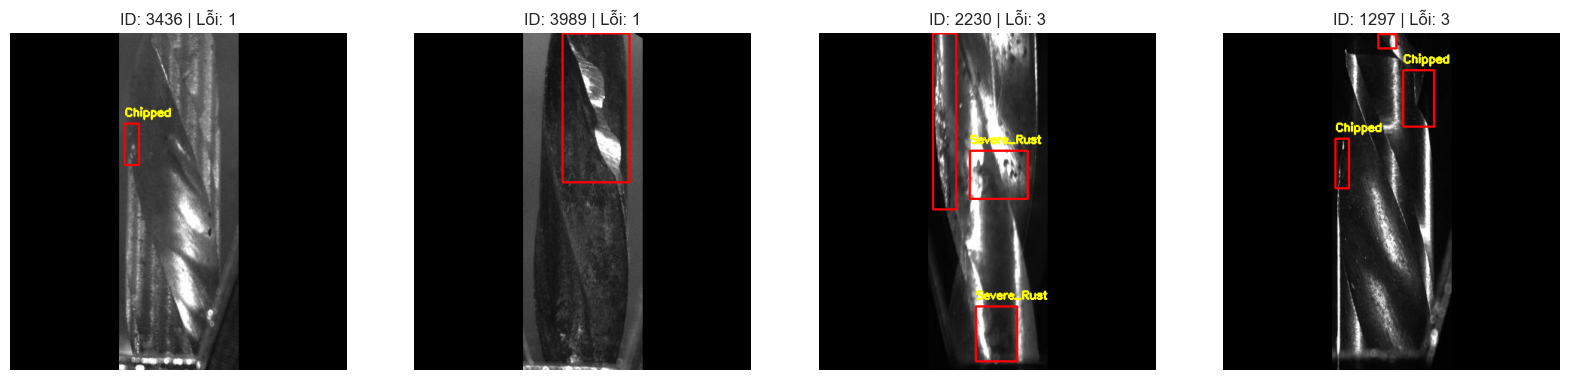

Đang vẽ biểu đồ thống kê...


/tmp/ipykernel_30643/2349568352.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=class_names, order=pd.Series(class_names).value_counts().index, ax=axs[0, 0], palette='viridis')


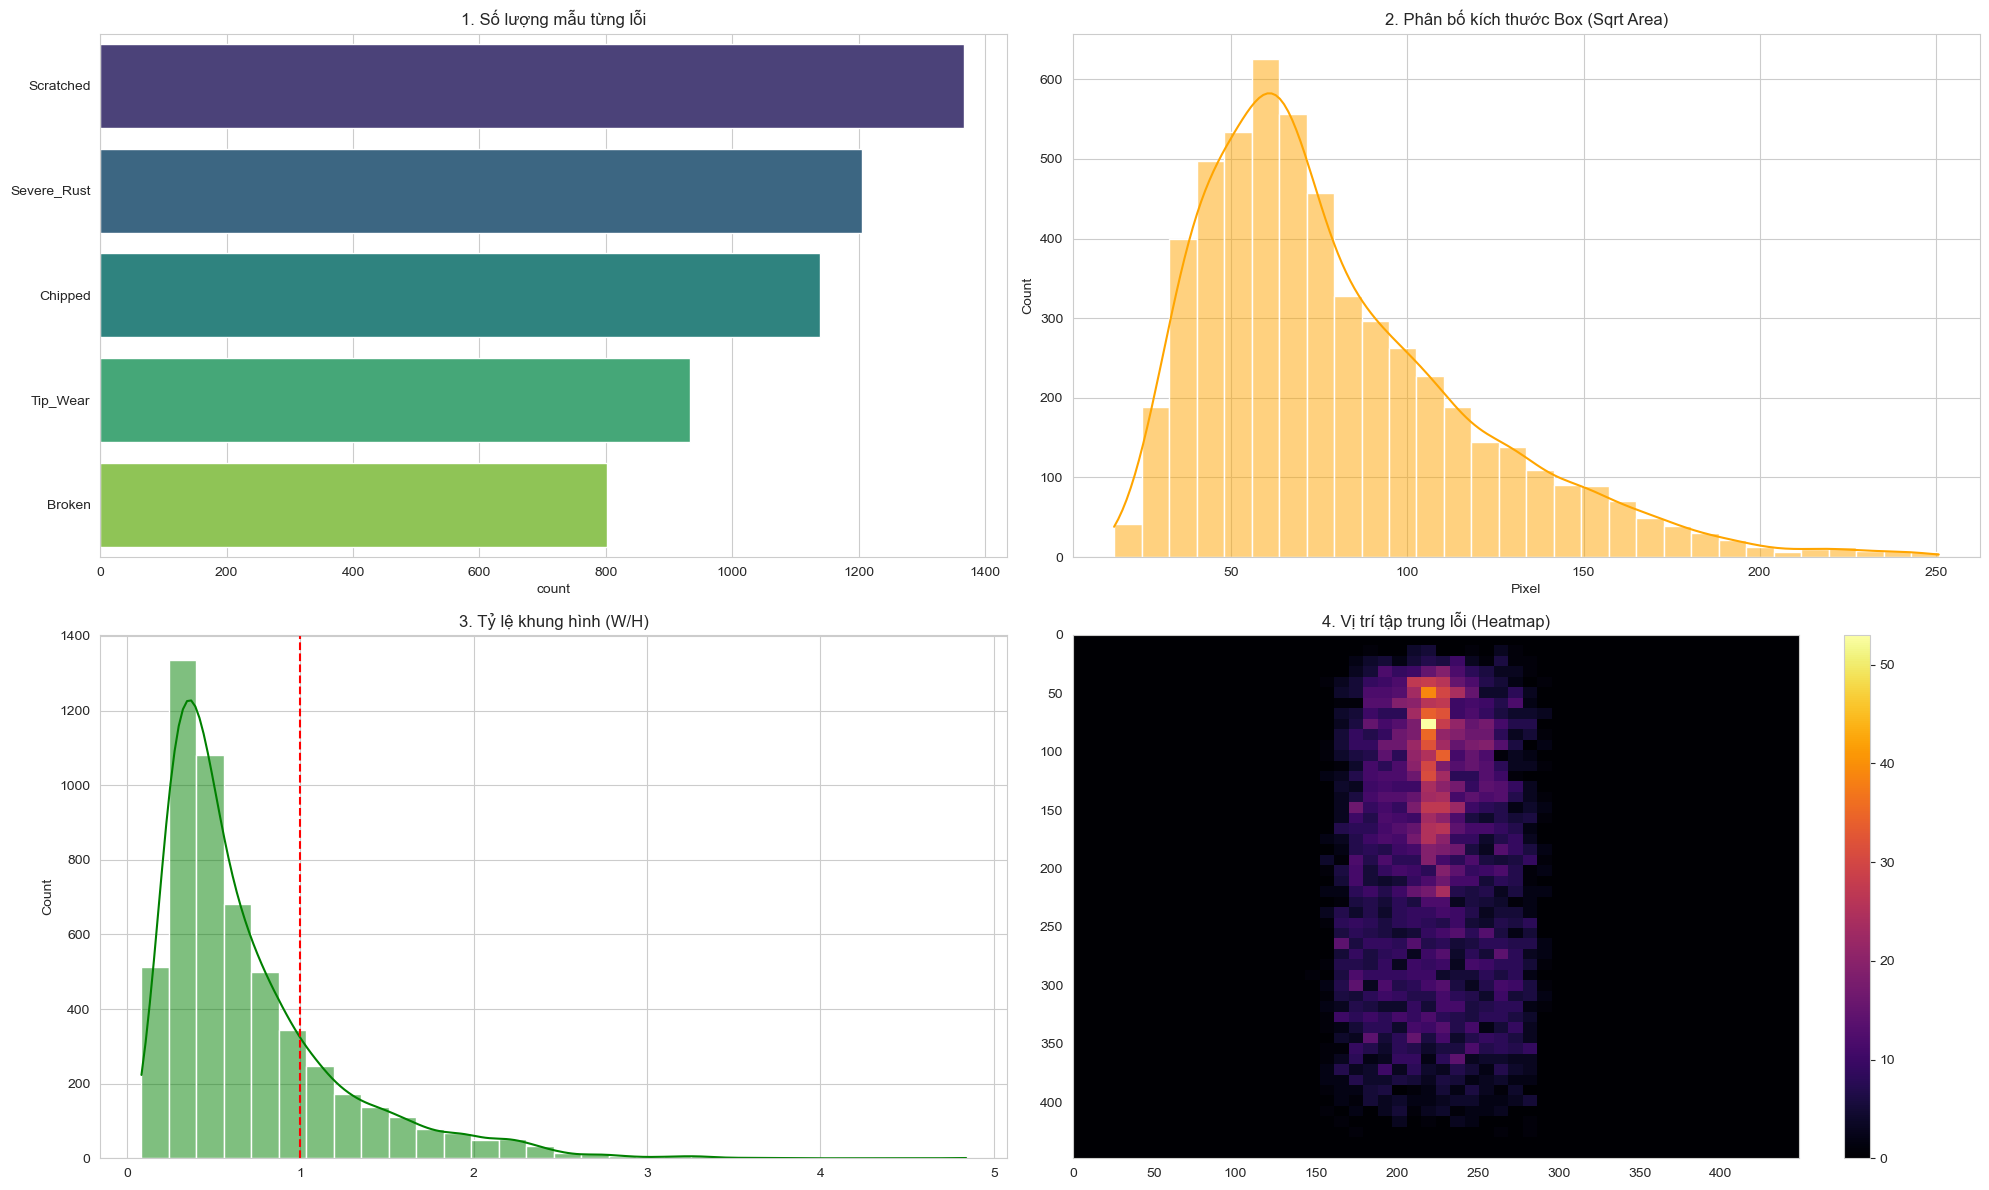

In [33]:
# 1. Đường dẫn (Cần thay đổi nếu khác máy bạn)
dataset_root = 'Data/Data_side/train'
json_file_path = dataset_root + '/_annotations.coco.json'

# 2. Tạo Index (Chỉ chạy 1 lần là dùng mãi)
my_image_map = create_file_index(dataset_root)

# 3. Thực thi phân tích
analyze_and_visualize(json_file_path, my_image_map, num_visualize=4)

In [34]:
def visualize_specific_class(json_path, image_map, target_class_name=None, num_samples=3):
    """
    target_class_name: Tên lỗi bạn muốn xem (VD: 'broken', 'crack'...). 
                       Nếu để None, code sẽ in ra danh sách các tên lỗi có sẵn để bạn chọn.
    """
    
    # Load dữ liệu
    with open(json_path, 'r') as f:
        coco = json.load(f)
        
    # Tạo map ngược: {Tên_lỗi -> ID_lỗi} và {ID_lỗi -> Tên_lỗi}
    cat_name_to_id = {cat['name']: cat['id'] for cat in coco['categories']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco['categories']}
    
    # --- Nếu người dùng chưa biết tên lỗi, in ra danh sách ---
    if target_class_name is None or target_class_name not in cat_name_to_id:
        print(f"⚠️ Vui lòng chọn một trong các tên lỗi sau để hiển thị:")
        print(list(cat_name_to_id.keys()))
        return

    target_id = cat_name_to_id[target_class_name]
    print(f"🔎 Đang tìm ảnh chứa lỗi: '{target_class_name}' (ID: {target_id})...")

    # --- Lọc danh sách các ảnh CHỈ chứa loại lỗi này ---
    # Bước 1: Tìm tất cả annotation ID thuộc class này
    target_img_ids = set()
    for ann in coco['annotations']:
        if ann['category_id'] == target_id:
            target_img_ids.add(ann['image_id'])
            
    # Bước 2: Lấy thông tin ảnh từ list ID trên
    candidate_images = [img for img in coco['images'] if img['id'] in target_img_ids]
    
    # Bước 3: Lọc những ảnh có file thực tế trên ổ cứng
    valid_images = []
    for img in candidate_images:
        fname = img['file_name']
        # Logic tìm kiếm file trong index map
        if fname in image_map:
            img['full_path'] = image_map[fname]
            valid_images.append(img)
        # Logic dự phòng (nếu tên file bị đổi chút xíu)
        elif '_crop' in fname:
             short_name = fname.split('_crop')[0]
             for k, v in image_map.items():
                 if short_name in k:
                     img['full_path'] = v
                     valid_images.append(img)
                     break
    
    if not valid_images:
        print(f"❌ Không tìm thấy ảnh nào chứa lỗi '{target_class_name}' trong thư mục.")
        return

    # --- Vẽ ảnh ---
    samples = random.sample(valid_images, min(num_samples, len(valid_images)))
    
    plt.figure(figsize=(20, 8))
    for i, img_info in enumerate(samples):
        path = img_info['full_path']
        img = cv2.imread(path)
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Lấy annotations của ảnh này
        anns = [a for a in coco['annotations'] if a['image_id'] == img_info['id']]
        
        # Vẽ Box
        for ann in anns:
            # Chỉ vẽ box của lỗi đang quan tâm cho đỡ rối (hoặc bỏ if này nếu muốn xem tất cả lỗi trên ảnh đó)
            if ann['category_id'] == target_id: 
                x, y, w, h = [int(v) for v in ann['bbox']]
                cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
                cv2.putText(img, target_class_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Lỗi: {target_class_name}\nFile: {os.path.basename(path)[:15]}...")
        
    plt.show()

In [36]:
visualize_specific_class(json_file_path, my_image_map, target_class_name=None)

⚠️ Vui lòng chọn một trong các tên lỗi sau để hiển thị:
['drill', 'Broken', 'Chipped', 'Scratched', 'Severe_Rust', 'Tip_Wear']


🔎 Đang tìm ảnh chứa lỗi: 'drill' (ID: 0)...
❌ Không tìm thấy ảnh nào chứa lỗi 'drill' trong thư mục.
🔎 Đang tìm ảnh chứa lỗi: 'Broken' (ID: 1)...


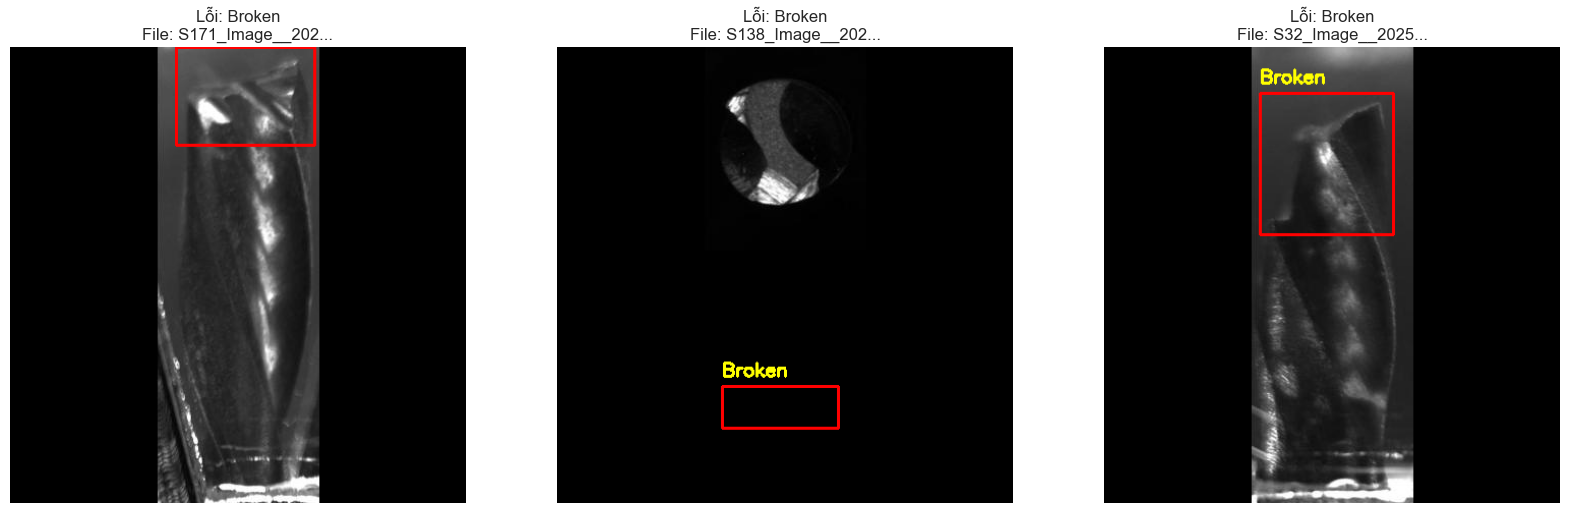

🔎 Đang tìm ảnh chứa lỗi: 'Chipped' (ID: 2)...


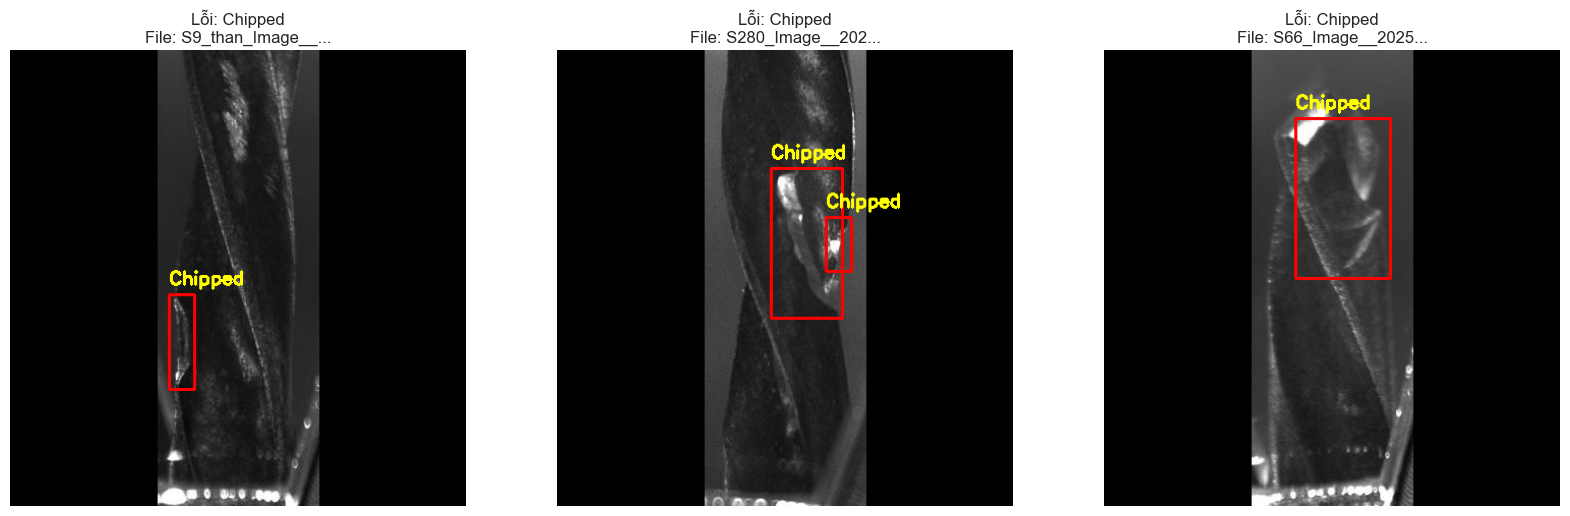

🔎 Đang tìm ảnh chứa lỗi: 'Scratched' (ID: 3)...


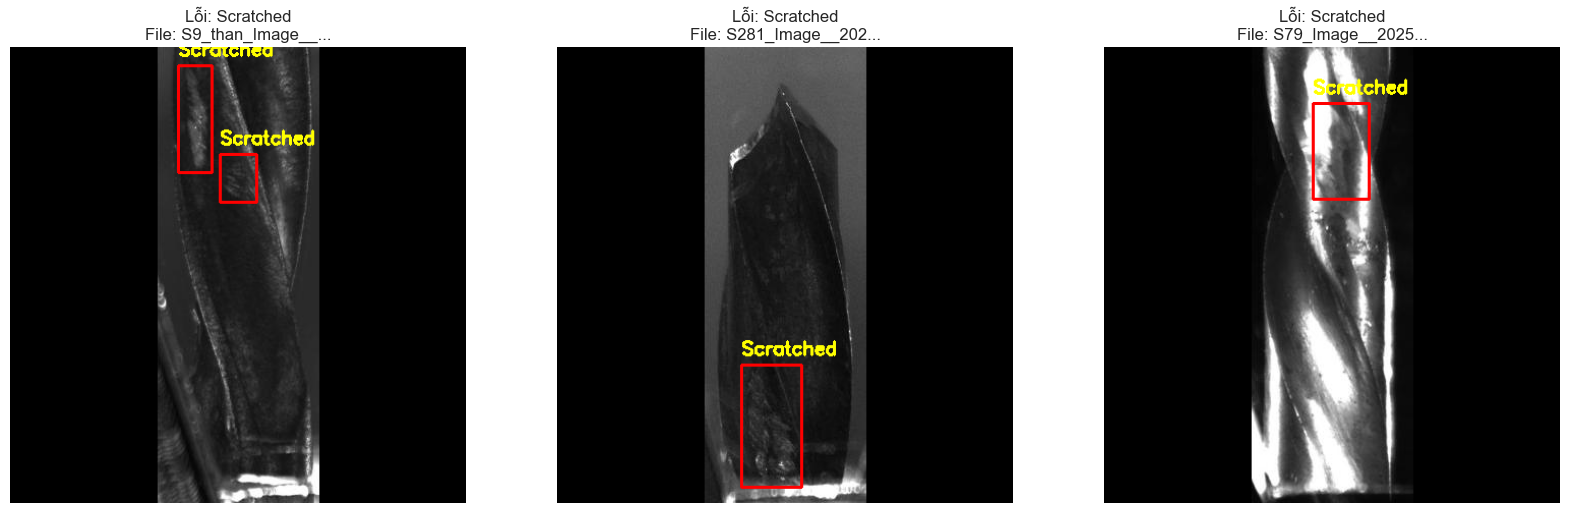

🔎 Đang tìm ảnh chứa lỗi: 'Severe_Rust' (ID: 4)...


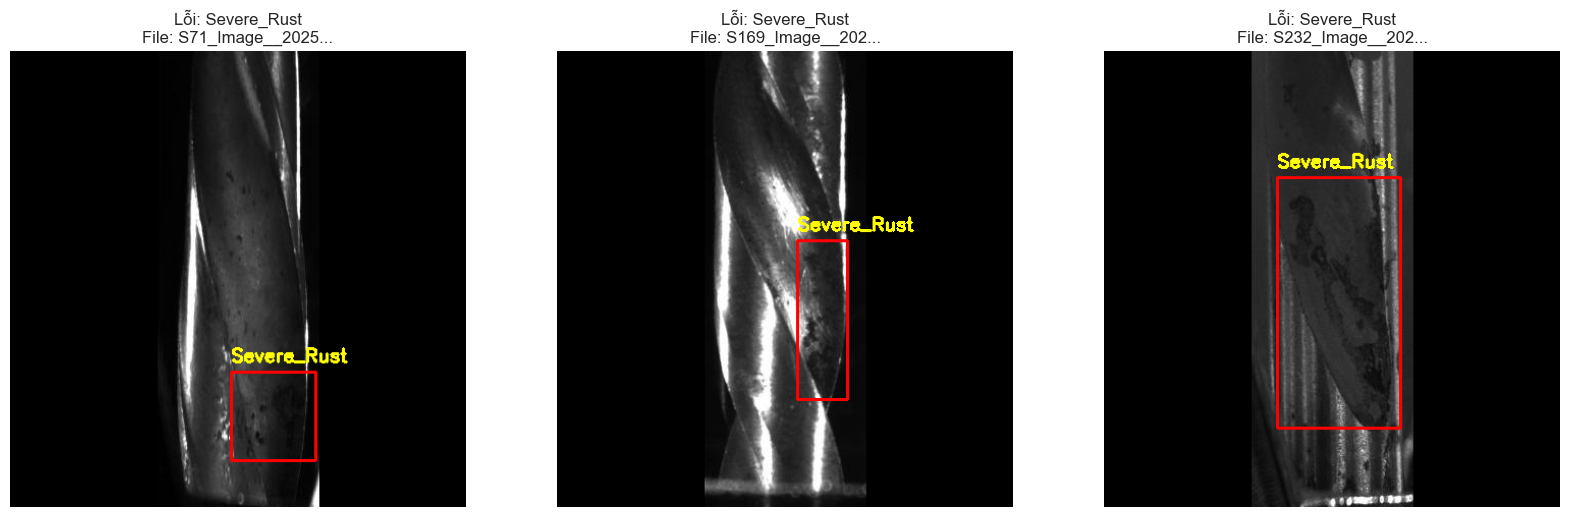

🔎 Đang tìm ảnh chứa lỗi: 'Tip_Wear' (ID: 5)...


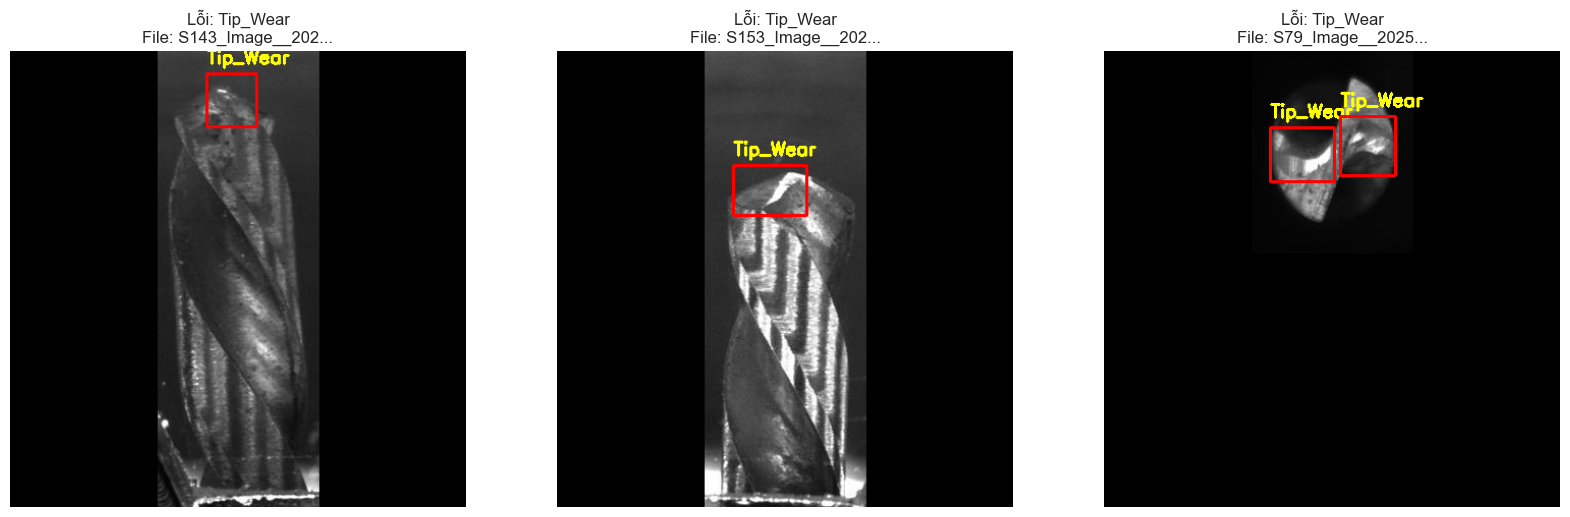

In [37]:
arr = ['drill', 'Broken', 'Chipped', 'Scratched', 'Severe_Rust', 'Tip_Wear']
for name in arr:
    visualize_specific_class(json_file_path, my_image_map, target_class_name=name)